# Chapter 4: Convolutional Neural Networks

In this chapter, we look into Convolutional Neural Networks (CNNs). First, we study the fundamental operations, convolution and pooling. Second, we look into padding as a way to modify the size of an input by adding columns and rows to it.

## 4.1 Convolution

Keras knows how to compute convolutions, so you don't have to worry to much about it in practice. However, it is still insightful to look at a concrete input (here: $6 \times 6$ and a concrete filter (here: $3 \times 3$) to study the output of the convolution. Note that the implementation of convolution that we use always pads the input to obtain an output having the same size (here: $6 \times 6$). You can control the padding behavior: the given code uses zeroes in the additional rows and columns.

In [1]:
import numpy as np
import scipy.ndimage as nd

# input as a 6 x 6 matrix
input = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                   [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])

# convolutional filter as a 3 x 3 matrix
filter = np.matrix([[1.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0],
                    [0.0, 0.0, 1.0]])

nd.convolve(input, filter, mode='constant')

array([[2., 0., 0., 0., 0., 0.],
       [0., 3., 1., 0., 0., 0.],
       [0., 0., 2., 2., 0., 0.],
       [0., 0., 0., 1., 3., 0.],
       [2., 0., 0., 0., 0., 2.],
       [0., 2., 0., 0., 0., 0.]])

## 4.2 Pooling

Similarly, you don't have to implement pooling in practice. However, it is still good to familiarize yourself with how it works. The following code applies max pooling to a concrete input (here: $6 \times 6$). Note that, as for convolution, the implementation always pads the input to obtain an output having the same size (here: $6 \times 6$).

In [2]:
import numpy as np
import scipy.ndimage as nd

input = np.matrix([[5.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 5.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 5.0, 0.0, 5.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 5.0, 0.0, 0.0, 0.0]])

nd.maximum_filter(input, (2,2), mode='constant')

array([[5., 5., 0., 0., 0., 0.],
       [5., 5., 0., 0., 0., 0.],
       [0., 0., 5., 5., 0., 0.],
       [0., 0., 5., 5., 5., 5.],
       [0., 0., 0., 5., 5., 5.],
       [0., 0., 5., 5., 0., 0.]])

## 4.3 Padding

While you typically don't have to take care of padding yourself, here is a small example that demonstrates how a matrix can be padded using functionality built into NumPy. When you define a layer in Keras, you only need to specify the options needed for padding.

In [3]:
import numpy as np

# initialize a 6 x 6 matrix filled with ones
input = np.ones((6,6))

# zero-pad the 6 x 6 matrix with one column at the top and bottom and one row to the left and right
np.pad(input, [(1, 1), (1, 1)], mode='constant')

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

## 4.4 CNN for Classifying Handwritten Digits

In the following, we revisit the problem of classifying handwritten digits from the MNIST dataset. Remember that we achieved an accuracy on our test data of slighty over 97.5% when using a fully connected feed-forward neural network with more than 111K parameters. Our CNN uses two convolutional layers with max pooling: the first layer uses 32 $(5 \times 5)$ convolutional filters with a stride of ($1 \times 1$); the second layer uses 64 $(5 \times 5)$ convolutional filters with a stride of ($1 \times 1$). Both layers are followed by $(2 \times 2)$ max-pooling layers using a stride of ($2 \times 2$). After flattening the output of the second max-pooling layer, a fully connected layer with 1024 neurons is used before producing the output.

For training the neural network, we rely on RMSProp, which is a variant of gradient-based optimization that adjusts the learning rate dynamically based on a running average of the gradient's magnitude. The method was first described in [lecture slides](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) by Geoffrey Hinton and is built into Keras.

Note that this neural-network architecture has more than 3.2M parameters, which is more than 30 times what our fully connected feed-forward neural network used. Training this network is fairly slow: one epoch takes close to a minute when training is done on a modern CPU and about 10 seconds on a modern GPU. In the end, this CNN achieves an accuracy of above 99.3% on our test data, which is a pretty good result. For ideas and approaches that have performed better than that, there is an [interesting discussion on Kaggle](https://www.kaggle.com/c/digit-recognizer/discussion/61480). As an aside, humans have been reported to achieve an accuracy of 99.8% on the MNIST test data.

In [4]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.utils import np_utils

# download MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape and normalize the data
X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels (0-9)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1024)              3

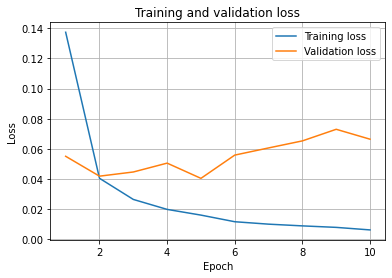

In [5]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

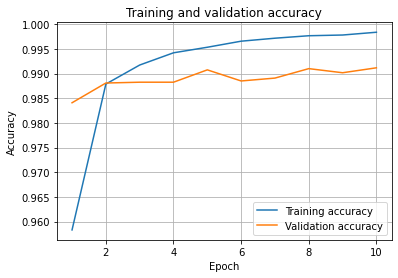

In [6]:
import matplotlib.pyplot as plt

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

As a next step, we try to radically simplify the architecture of the neural network by reducing the size of the convolutional filters to ($3 \times 3$) and also refraining from using padding. The first convolutional layer uses 32 filters; the second convolutional layer uses only 32 filters. In addition, we reduce the number of neurons in the fully connected layer that precedes the output to 64. As you can see from the model summary, there are now only slightly more than 60K parameters left to train. This simplified model is still able to achieve an accuracy of around 99% on the test data. Note that, due to the sampling in gradient-based optimization, you might observe slight fluctuations in accuracy when repeatedly training the model.

In [7]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

from keras.utils import np_utils

# download MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape and normalize the data
X_train = X_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels (0-9)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

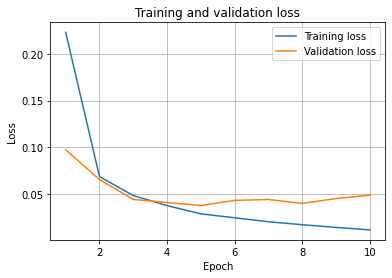

In [8]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

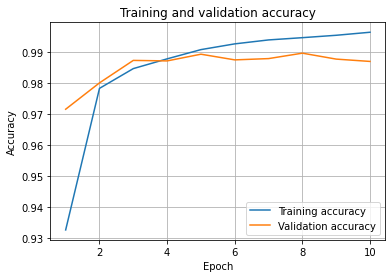

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

One common criticism regarding neural networks is that it is hard to understand what they actually learn. While they are clearly not as easily interpretable as, say, decision trees, we can still obtain an insight into what the convolutional filters and pooling filters learn. The following code, adapted from Chollet's book, shows how this can be done. From the learnt filters, we construct a so-called activation model, which records the output of the individual filters. We can then run one of our training examples through this activation model, and visualize how the learnt filters react to it.

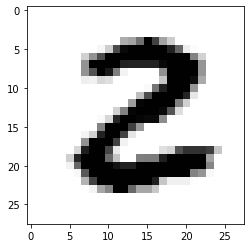

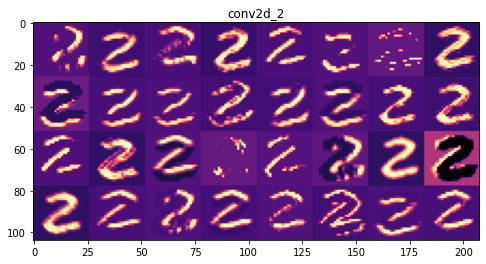

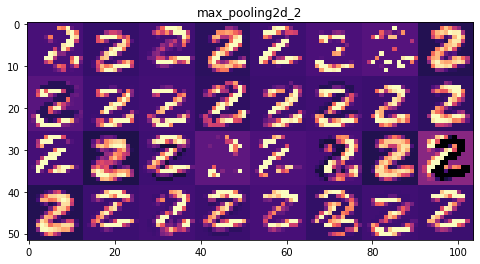

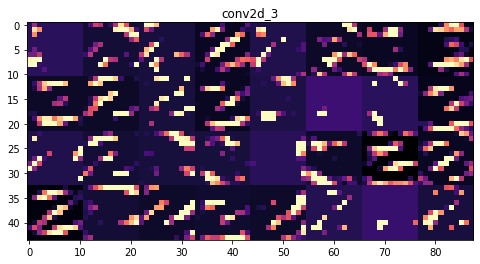

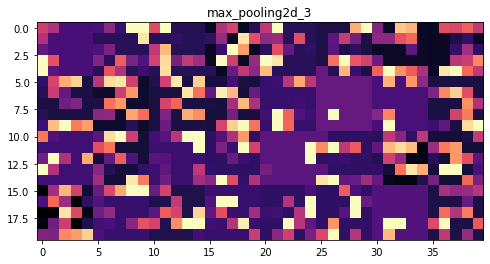

In [10]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from keras import models
from keras.datasets import mnist
import matplotlib.pyplot as plt

# download MNIST dataset
(images_train, labels_train), (images_test, labels_test) = mnist.load_data()

# MNIST image to use
img = 25

# show the selected image
plt.imshow(images_train[img], cmap=plt.cm.binary)
plt.show()

# reshape and normalize the data
X_train = images_train.reshape((60000, 28, 28, 1))
X_train = X_train.astype('float32') / 255
X_test = images_test.reshape((10000, 28, 28, 1))
X_test = X_test.astype('float32') / 255

# create an activations model
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[img:(img+1)])

# consider only the first two convolutional and pooling layers
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

# numer of images to display per row    
images_per_row = 8

# run the image through every convolutional filter and corresponding pooling filter
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)    
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='magma')
    plt.imshow

## 4.5: Data Augmentation

In the following example, we will look into classifying RGB images of cats and dogs. This changes the architecture of our neural network slightly, since each training example will now be a 150 x 150 x 3 tensor. The images have a size of 150 x 150 and we have three colour channels (R, G, B). We will use four convolutional layers with (3 x 3) pooling filters, each followed by a max-pooling layer with (2 x 2) filters. The dataset that is used for this example is a subset of a dataset from Kaggle and is available in Moodle. It consists of 2,000 training images, 1,000 validation images, and 1,000 test images.

In [12]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# paths where training, validation, and test images reside
train_dir='../data/cats_and_dogs_small/train'
validation_dir='../data/cats_and_dogs_small/validation'
test_dir='../data/cats_and_dogs_small/test'

# we use generators to iterate over the training and validation images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(150, 150), 
                                                              batch_size=20, 
                                                              class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

# define the architecture of our neural network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

# fit the model
history = model.fit(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30,
                              validation_data=validation_generator, 
                              validation_steps=50)

# save the model
model.save('cats_and_dogs_small_1.h5')

# compute loss and accuracy on test data
score = model.evaluate(test_generator)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856

Our model achieves an accuracy of more than 71% on our test data, which is substantially better than the 50% that a random baseline would achieve.

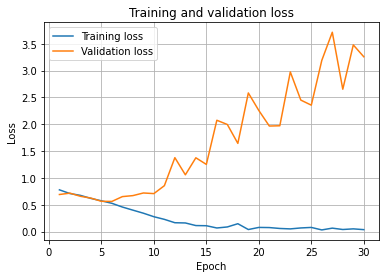

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

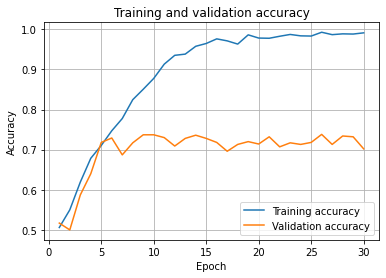

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

From the above plot of training and validation loss, we can see that our model starts overfitting. From the plot for training and validation accuracy, we can see that the accuracy on the validation data keeps fluctuating around 70% after epoch 10, so we could have stopped training then.

We'll now use data augmentation on the training data. The `ImageDataGenerator` systematically applies several random transformations to our training images (e.g., by rotating, shifting, or flipping them). Note that these transformations are only applied to our training data; the validation and test data remain unchanged.

In [15]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# paths where training, validation, and test images reside
train_dir='../data/cats_and_dogs_small/train'
validation_dir='../data/cats_and_dogs_small/validation'
test_dir='../data/cats_and_dogs_small/test'

# we use generators to iterate over the training and validation images
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(150, 150), 
                                                              batch_size=20, 
                                                              class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

# define the architecture of our netural network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

# fit the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

# save the model
model.save('cats_and_dogs_small_2.h5')

# compute loss and accuracy on test data
score = model.evaluate(test_generator)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

As we can see, augmenting the training data helps to improve our model. It achieves an accuracy of more than 80% on our test data. Also, while the validation loss and accuracy now fluctuate due to the randomly transformed training data, they remain closer to the loss and accuracy on the training data.

However, due to these fluctuations, it could happen that we end with a model that performs worse on our validation data than a model from a previous epoch. To avoid this, Keras provides so-called callbacks, which allow stopping training early (e.g., when the loss does not improve for a specified number of epochs) or memorizing the best model seen. The following code extends the above example by adding a callback to remember the best model seen.

In [ ]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# paths where training, validation, and test images reside
train_dir='../data/cats_and_dogs_small/train'
validation_dir='../data/cats_and_dogs_small/validation'
test_dir='../data/cats_and_dogs_small/test'

# we use generators to iterate over the training and validation images
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(150, 150), 
                                                              batch_size=20, 
                                                              class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

# define the architecture of our netural network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

# where to save the model checkpoint
checkpoint_filepath = './cats_and_dogs.h5.checkpoint'

# define model checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

# fit the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[model_checkpoint_callback])

# load best model from checkpoint
model.load_weights(checkpoint_filepath)

# compute loss and accuracy on test data
score = model.evaluate(test_generator)
print("Test score:", score[0])
print("Test accuracy:", score[1])

## 4.6 Pre-Trained Networks

In this example, we will use a pre-trained network and build on it to address the problem of classifying cats and dogs. The network that we are going to use is [VGG16](https://arxiv.org/pdf/1409.1556.pdf), which was designed to wo work on the [ImageNet](http://www.image-net.org) dataset, which consists of more than 15M images from 220K classes. This [blog post](https://medium.com/mlearning-ai/an-overview-of-vgg16-and-nin-models-96e4bf398484) provides a more accessible description of the VGG16 network. Thus, this is a much bigger dataset than the one we are using, and the number of classes is also significantly larger. However, we can make use of the pre-trained VGG16 network as follows: we can retain its convolutional layers and replace its fully connected layer, which takes care of learning to classify based on the features learnt by the convolutional layers, by our own layers. It is important to exclude the convolutional layers taken from VGG16 from training, i.e., their parameters are fixed and will not be modified during training.

In [ ]:
# turn off tensorflow info and warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras import models
from keras import layers
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator

# download VGG16 model for image classification, but exclude classification head
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# define the architecture of the neural network building on VGG15
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
conv_base.trainable = False
model.summary()

# paths where training, validation, and test images reside
train_dir='../data/cats_and_dogs_small/train'
validation_dir='../data/cats_and_dogs_small/validation'
test_dir='../data/cats_and_dogs_small/test'

# we use generators to iterate over the training and validation images
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(150, 150), 
                                                              batch_size=20, 
                                                              class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

# save the model
model.save('cats_and_dogs_small_3.h5')

# compute loss and accuracy on test data
score = model.evaluate(test_generator)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Using a pre-trained network allows us to improve our accuracy on the test data to more than 88%. Furthermore, we achieve this after only 30 epochs and thus shorter time for training.

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Leveraging the pretrained model, gives us the best model on the cats vs. dogs data so far. Interestingly, in this case, the performance of the model is almost consistently better on the validation data than on the training data. This hints at the randomly transformed training images being very different from what was used to train VGG16, while our non-transformed validation data is more similar to what VGG16 knows.

In [ ]:
# produce predictions for test images
test_generator.reset()
Y_hat = model.predict(test_generator)

# create list of test images
test_images = []
test_generator.reset()
for i in range(0,50):
    data = test_generator.next()
    for test_image in data[0]:
        test_images.append(test_image)

# define function to compute entropy
def entropy(p):
    return -sum([prob*math.log2(prob) for prob in p])

# compute entropy for each data point in the test data
entropies = np.apply_along_axis(entropy, 1, Y_hat)

# sort test data points in descending order of entropy
indices = list(range(0, len(Y_hat)))
indices.sort(key = lambda i : -entropies[i])

# show top-10 confusing images
for i in range(0, 10):
    print(indices[i])
    print(entropies[indices[i]])
    print(Y_hat[indices[i]])
    plt.imshow(test_images[indices[i]])
    plt.show()